In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import math
import seaborn as sns
import lightgbm as lgbm
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler

In [2]:
items = pd.read_csv("items.csv")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv")
sample_submission = pd.read_csv("sample_submission.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

<AxesSubplot:xlabel='item_price'>

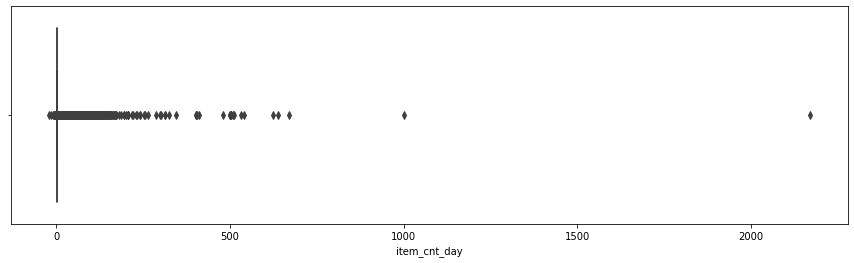

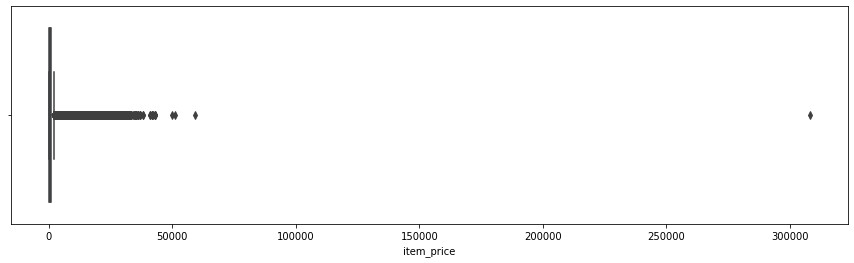

In [5]:
plt.figure(figsize=(15,4))
sns.boxplot(x = sales_train.item_cnt_day)

plt.figure(figsize=(15,4))
sns.boxplot(x = sales_train.item_price)

In [6]:
# Remove Outliers
sales_train = sales_train[sales_train.item_cnt_day < 2000]
sales_train = sales_train[sales_train.item_price < 300000]

In [7]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
count,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06
mean,1.456991e+01,3.300174e+01,1.019723e+04,8.907489e+02,1.241903e+00,3.365687e+00,6.247714e+00,2.013777e+03
std,9.422985e+00,1.622697e+01,6.324299e+03,1.720490e+03,2.292963e+00,1.996796e+00,3.536218e+00,7.684788e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,1.000000e+00,2.013000e+03
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.000000e+00,3.000000e+00,2.013000e+03
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+00,6.000000e+00,2.014000e+03
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.000000e+00,9.000000e+00,2.014000e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,1.000000e+03,6.000000e+00,1.200000e+01,2.015000e+03


In [7]:
sales_train[sales_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
# We see that there is one item price below zero with shop_id 32 and item_id 2973
# We can replace these prices with the median of the same item at the same shop
median = sales_train[[a and b for a, b in zip(list(sales_train.item_id == 2973), list(sales_train.shop_id == 32))]].item_price.median()
sales_train.loc[sales_train.item_price < 0, 'item_price'] = median

In [9]:
# Make pairs with datenum up to 34 to include test set
pairs = [(x, y, z) for x in range(35) for y in shops.shop_id.unique() for z in items.item_id.unique()]

In [10]:
vstack = np.vstack(pairs)
vstackdf = pd.DataFrame(vstack, columns = ['date_block_num', 'shop_id', 'item_id'])

In [11]:
# Get the mean of the items sold per month per shop per item and the median price
group = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg({"item_cnt_day" : ['sum'], "item_price" : ['median']})
group.reset_index(inplace=True)

In [13]:
new_sales_data = pd.merge(vstackdf, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')

/home/vincent/kaggle/predictFutureSales/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/vincent/kaggle/predictFutureSales/venv/lib/python3.8/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [14]:
new_sales_data.fillna(0, inplace=True)

In [15]:
new_sales_data['month'] = new_sales_data['date_block_num'].apply(lambda x: (x + 2) % 13)

In [16]:
# Rename columns for ease
new_sales_data.rename(columns = {('item_price', 'median'): "avg_item_price", ('item_cnt_day', 'sum'): "item_cnt_month"}, inplace=True)

In [17]:
new_sales_data['item_sold'] = new_sales_data['avg_item_price'].apply(lambda x: 1 if x != 0.0 else 0)

In [18]:
def addPrevMonths(data, prevCount, column, name):
    data_column = data[column]
    data_column = 1330200 * prevCount * [-1] + list(data_column)
    data_column = data_column[:-(1330200 * prevCount)]
    data[name] = data_column
    
def addCumPrevMonths(data, prevCount, column, name):
    data_column = list(data[column])
    temp_column = data_column.copy()

    data_column = [0 for _ in data_column]
    for _ in range(0, prevCount):
        temp_column = 1330200 * [0] + temp_column
        temp_column = temp_column[:-(1330200)]
        data_column = [x + y for x, y in zip(data_column, temp_column)]
    data[name] = data_column

def lastSale(data, column, name):
    data_column = list(data[column])
    temp_column = data_column.copy()
    data_column = [-1 for _ in data_column]
    
    for index in range(35):
        data_column = [index if new_sale > 0 else old_sale for old_sale, new_sale in zip(data_column, temp_column)]
        temp_column = 1330200 * [0] + temp_column
        temp_column = temp_column[:-1330200]
   
    data[name] = data_column
        
    

In [20]:
addPrevMonths(new_sales_data, 1, 'item_cnt_month', 'item_cnt_prev1_month')
addPrevMonths(new_sales_data, 2, 'item_cnt_month', 'item_cnt_prev2_month')
addPrevMonths(new_sales_data, 3, 'item_cnt_month', 'item_cnt_prev3_month')
addPrevMonths(new_sales_data, 4, 'item_cnt_month', 'item_cnt_prev4_month')
addPrevMonths(new_sales_data, 6, 'item_cnt_month', 'item_cnt_prev6_month')
addPrevMonths(new_sales_data, 12, 'item_cnt_month', 'item_cnt_prev12_month')

In [22]:
addCumPrevMonths(new_sales_data, 2, 'item_cnt_month', 'item_cnt_cum_prev2_month')
addCumPrevMonths(new_sales_data, 3, 'item_cnt_month', 'item_cnt_cum_prev3_month')
addCumPrevMonths(new_sales_data, 4, 'item_cnt_month', 'item_cnt_cum_prev4_month')
addCumPrevMonths(new_sales_data, 6, 'item_cnt_month', 'item_cnt_cum_prev6_month')
addCumPrevMonths(new_sales_data, 12, 'item_cnt_month', 'item_cnt_cum_prev12_month')

In [23]:
# Add total sales per item per shop per month since the beginning of the dataset up to the specified time
addCumPrevMonths(new_sales_data, 35, 'item_cnt_month', 'item_cnt_total')

In [24]:
# Get the last month that an item per shop per month was last sold
lastSale(new_sales_data, 'item_cnt_month', 'item_last_sale_month')

In [27]:
# Get the average sales per month
group2 = new_sales_data.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group2.reset_index(inplace=True)

<AxesSubplot:>

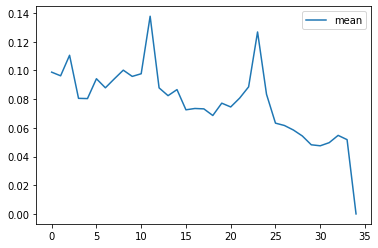

In [54]:
group2.item_cnt_month.plot()

In [7]:
# From the plot above, we can see that there are two 'spikes' around the 11th and 23rd month
# So any month in which the data_block_num %13 == 11 is significant
group2[(group2.item_cnt_month > 0.12).values]

,date_block_num,item_cnt_month
,,mean
11,11,0.137830
23,23,0.126864


In [29]:
new_sales_data = pd.merge(new_sales_data, group2, on=['date_block_num'], how='left')
new_sales_data.rename(columns = {('item_cnt_month', 'mean'): "month_avg_sales"}, inplace=True)

/home/vincent/kaggle/predictFutureSales/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/vincent/kaggle/predictFutureSales/venv/lib/python3.8/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [31]:
# We found that the peak months occur on the 11th month of a year, so make a binary variable saying if the current
# month is the 11th month of the year
new_sales_data['peak_month'] = new_sales_data['date_block_num'].apply(lambda x: 1 if x % 12 == 11 else 0)

In [32]:
# Change the datatype of these columns in order to save space
new_sales_data.info()
new_sales_data['date_block_num'] = new_sales_data['date_block_num'].astype(np.int16)
new_sales_data['shop_id'] = new_sales_data['shop_id'].astype(np.int16)
new_sales_data['month'] = new_sales_data['month'].astype(np.int16)
new_sales_data['item_sold'] = new_sales_data['item_sold'].astype(np.int16)
new_sales_data['item_cnt_month'] = new_sales_data['item_cnt_month'].astype(np.int16)
new_sales_data['avg_item_price'] = new_sales_data['avg_item_price'].astype(np.float16)
new_sales_data['item_cnt_prev1_month'] = new_sales_data['item_cnt_prev1_month'].astype(np.int16)
new_sales_data['item_cnt_prev2_month'] = new_sales_data['item_cnt_prev2_month'].astype(np.int16)
new_sales_data['item_cnt_prev3_month'] = new_sales_data['item_cnt_prev3_month'].astype(np.int16)
new_sales_data['item_cnt_prev4_month'] = new_sales_data['item_cnt_prev4_month'].astype(np.int16)
new_sales_data['item_cnt_prev6_month'] = new_sales_data['item_cnt_prev6_month'].astype(np.int16)
new_sales_data['item_cnt_prev12_month'] = new_sales_data['item_cnt_prev12_month'].astype(np.int16)
new_sales_data['item_cnt_cum_prev12_month'] = new_sales_data['item_cnt_cum_prev12_month'].astype(np.int16)
new_sales_data['item_cnt_cum_prev2_month'] = new_sales_data['item_cnt_cum_prev2_month'].astype(np.int16)
new_sales_data['item_cnt_cum_prev3_month'] = new_sales_data['item_cnt_cum_prev3_month'].astype(np.int16)
new_sales_data['item_cnt_cum_prev4_month'] = new_sales_data['item_cnt_cum_prev4_month'].astype(np.int16)
new_sales_data['item_cnt_cum_prev6_month'] = new_sales_data['item_cnt_cum_prev6_month'].astype(np.int16)
new_sales_data['item_cnt_total'] = new_sales_data['item_cnt_total'].astype(np.int16)
new_sales_data['item_last_sale_month'] = new_sales_data['item_last_sale_month'].astype(np.int16)
new_sales_data['peak_month'] = new_sales_data['peak_month'].astype(np.int16)
new_sales_data['month_avg_sales'] = new_sales_data['month_avg_sales'].astype(np.float16)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 46557000 entries, 0 to 46556999
Data columns (total 22 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   date_block_num             int64  
 1   shop_id                    int64  
 2   item_id                    int64  
 3   item_cnt_month             float64
 4   avg_item_price             float64
 5   month                      int64  
 6   item_sold                  int64  
 7   item_cnt_prev1_month       float64
 8   item_cnt_prev2_month       float64
 9   item_cnt_prev3_month       float64
 10  item_cnt_prev4_month       float64
 11  item_cnt_prev6_month       float64
 12  item_cnt_prev12_month      float64
 13  item_cnt_cum_prev12_month  float64
 14  item_cnt_cum_prev2_month   float64
 15  item_cnt_cum_prev3_month   float64
 16  item_cnt_cum_prev4_month   float64
 17  item_cnt_cum_prev6_month   float64
 18  item_cnt_total             float64
 19  item_last_sale_month       int64  
 20  

In [33]:
# Get the average sales per month
group3 = new_sales_data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group3.reset_index(inplace=True)

In [35]:
new_sales_data = pd.merge(new_sales_data, group3, on = ['date_block_num', 'shop_id'], how = 'left')
new_sales_data.rename(columns = {('item_cnt_month', 'mean'): "shop_avg_sales"}, inplace=True)

In [37]:
# Get the average sales of each item per month
group4 = new_sales_data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': 'mean'})
group4.reset_index(inplace=True)

In [39]:
new_sales_data = pd.merge(new_sales_data, group4, on = ['date_block_num', 'item_id'], how = 'left')
new_sales_data.rename(columns = {'item_cnt_month_y': "item_avg_sales"}, inplace=True)

In [41]:
# Add item categories to data so that we can aggregate by item categories
new_sales_data['item_category'] = new_sales_data['item_id'].apply(lambda x: items.loc[x, 'item_category_id'])

In [45]:
# Merge sometimes has same columns, so creates two variables with slightly different names; rename the columns
new_sales_data.rename(columns = {'item_cnt_month_x': 'item_cnt_month'}, inplace=True)

In [47]:
new_sales_data = pd.merge(new_sales_data, group5, on = ['date_block_num', 'item_category'], how = 'left')
new_sales_data.rename(columns = {"item_cnt_month_x" : "item_cnt_month", "item_cnt_month_y" : "category_avg_sales"}, inplace=True)
new_sales_data.rename(columns = {"shop_avg_sales" : "month_shop_avg_sales", "item_avg_sales" : "month_item_avg_sales", "category_avg_sales" : "month_category_avg_sales"}, inplace=True)

In [50]:
# Get more general categories from the list of provided categories
general_categories = {}
for x in item_categories['item_category_name']:
    splits = x.split()
    for split in splits:
        if split == '-':
            continue
        if split not in general_categories.keys():
            general_categories[split] = []    
        general_categories[split].append(x)

In [52]:
index2generalkey = {}
for x in range(84):
    index2generalkey[x] = tuple([key for key in general_categories.keys() if item_categories.loc[x, 'item_category_name'] in general_categories[key]])

In [53]:
new_sales_data['general_categories'] = new_sales_data['item_category'].apply(lambda x: index2generalkey[x])

In [60]:
# Get the average sales of each item category per month
group5 = new_sales_data.groupby(['date_block_num', 'item_category']).agg({'item_cnt_month': 'mean'})
group5.reset_index(inplace=True)
group5['item_category_name'] = group5['item_category'].apply(lambda x: item_categories.loc[x, 'item_category_name'])

In [63]:
def sumIndivCategories(date_block_num, categories):
    tot = 0
    for gen_cat in categories:
        for indiv_cat in general_categories[gen_cat]:
            tot += list(group5[[a and b for a, b in zip(group5['item_category_name'] == indiv_cat, group5["date_block_num"] == date_block_num)]].item_cnt_month)[0]
    return tot

In [64]:
# Get the average items sold per general category per month
group6 = new_sales_data.groupby(['date_block_num', 'general_categories']).agg({'item_cnt_month': 'mean'})
group6.reset_index(inplace=True)
group6['item_cnt_month2'] = group6.apply(lambda x: sumIndivCategories(x.date_block_num, x.general_categories), axis =1)
group6.drop("item_cnt_month", axis = 1, inplace=True)
group6.rename(columns = {"item_cnt_month2" : "month_gen_categories_avg_sale"}, inplace=True)

In [67]:
new_sales_data = pd.merge(new_sales_data, group6, on=['date_block_num', 'general_categories'], how='left')

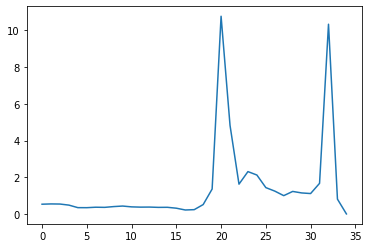

In [141]:
#Check some plots to see if we can find any significant monthly spikes in sales
plt.plot(list(group6[group6.general_categories == ('(Цифра)', 'MAC', 'Программы')].item_cnt_month2))

In [68]:
general_categories_peaks = {}
for x in group6.general_categories:
    general_categories_peaks[x] = list(group6[group6.general_categories == x].month_gen_categories_avg_sale)

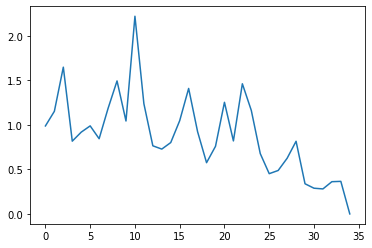

In [319]:
plt.plot(general_categories_peaks[list(general_categories_peaks.keys())[6]])

In [ ]:
for index, key in enumerate(general_categories_peaks.keys()):
    print(index, [(index, value) for index, value in enumerate(general_categories_peaks[key]) if value >= list(pd.DataFrame(general_categories_peaks[list(general_categories_peaks.keys())[0]]).quantile(0.95))[0]])

In [70]:
# Get the average popularity of each item in terms of sales across all of the data
total_item_popularity_group = new_sales_data.groupby(["item_id"]).agg({'item_cnt_month': ['mean']})
total_item_popularity_group.reset_index(inplace=True)
new_sales_data = pd.merge(new_sales_data, total_item_popularity_group, on = ['item_id'], how = 'left')
new_sales_data.rename(columns = {('item_cnt_month', 'mean'): 'tot_item_avg_popularity'}, inplace=True)

In [22]:
# Rename all columns to avoid ambiguity
new_names = "dateBlockNum shopId itemId itemCountPerShopPerMonth avergageItemPricePerShopPerMonth monthOfYear isItemSoldThisShopThisMonth itemsSoldPerShopPerMonth1MonthAgo itemsSoldPerShopPerMonth2MonthsAgo itemsSoldPerShopPerMonth3MonthsAgo itemsSoldPerShopPerMonth4MonthsAgo itemsSoldPerShopPerMonth6MonthsAgo itemsSoldPerShopPerMonth12MonthsAgo totItemsSoldPerShopPerMonthLast12Months totItemsSoldPerShopPerMonthLast2Months totItemsSoldPerShopPerMonthLast3Months totItemsSoldPerShopPerMonthLast4Months totItemsSoldPerShopPerMonthLast6Months totItemsSoldPerShopPerMonthSinceBeginning itemLastMonthSoldPerShop peakMonthOfYearForSelling? monthAverageSales monthAverageSalesPerShop monthAverageSalesPerItem itemCategory monthAverageSalesPerItemCategory generalItemCategories monthAverageSalesPerGeneralItemCategories itemAverageSalesSinceBeginning"
new_names = new_names.split()

renames = {}
for a, b in zip(list(new_sales_data.columns), new_names):
    renames[a] = b

new_sales_data.rename(columns = renames, inplace=True)

In [84]:
new_sales_data['generalItemCategoriesEncoded'] = LabelEncoder().fit_transform(new_sales_data['generalItemCategories'])

In [85]:
shop_city = {}
for x in shops['shop_name']:
    splits = x.split()
    if splits[0] not in shop_city.keys():
        shop_city[splits[0]] = []
    shop_city[splits[0]].append(x)
    
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])

shopindex2city = {}
for index in shops.shop_id:
    shopindex2city[index] = list(shops[shops['shop_id'] == index].city)[0]
    
    
    
new_sales_data['city'] = new_sales_data['shopId'].apply(lambda x: shopindex2city[x])
new_sales_data['cityEncoded'] = LabelEncoder().fit_transform(new_sales_data['city'])

In [90]:
month_city_item_count = new_sales_data.groupby(['dateBlockNum', 'itemId','city']).agg({'itemCountPerShopPerMonth': ['mean']})
month_city_item_count.columns = ['itemAverageSalesPerCityPerMonth']
month_city_item_count.reset_index(inplace=True)
new_sales_data = pd.merge(new_sales_data, month_city_item_count, on = ['dateBlockNum', 'itemId', 'city'], how='left')

month_city = new_sales_data.groupby(['dateBlockNum', 'city']).agg({"itemCountPerShopPerMonth":['mean']})
month_city.columns = ['averageSalesPerCityPerMonth']
month_city.reset_index(inplace=True)
new_sales_data = pd.merge(new_sales_data, month_city, on = ['dateBlockNum', 'city'], how = 'left')

city_average_sales = new_sales_data.groupby(['city']).agg({"itemCountPerShopPerMonth":['mean']})
city_average_sales.columns = ['cityAverageSales']
city_average_sales.reset_index(inplace=True)
new_sales_data = pd.merge(new_sales_data, city_average_sales, on = ['city'], how = 'left')

month_city_item_total_sales = new_sales_data.groupby(['dateBlockNum', 'itemId', 'city']).agg({'itemCountPerShopPerMonth':['sum']})
month_city_item_total_sales.columns = ['totalSalesPerItemPerCityPerMonth']
month_city_item_total_sales.reset_index(inplace=True)
new_sales_data = pd.merge(new_sales_data, month_city_item_total_sales, on = ['dateBlockNum', 'itemId', 'city'], how = 'left')

In [4]:
temp = new_sales_data.groupby(['dateBlockNum'])

In [5]:
def getCumMonths(temp, months):
    tot = []
    for month in [list(temp.first()['monthAverageSales'].shift(periods=x, fill_value=0)) for x in range(1, months+1)]:
        if tot == []:
            tot = month
        else:
            tot = [a+b for a, b in zip(tot, month)]
    return tot

In [6]:
new_sales_data['monthAverageSalesLast1Month'] = new_sales_data['monthAverageSales'].shift(periods=1330200, fill_value=0)
new_sales_data['monthAverageSalesLast2Month'] = new_sales_data['monthAverageSales'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast3Month'] = new_sales_data['monthAverageSales'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast4Month'] = new_sales_data['monthAverageSales'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast6Month'] = new_sales_data['monthAverageSales'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast12Month'] = new_sales_data['monthAverageSales'].shift(periods=12*1330200, fill_value=0)

cum_list = getCumMonths(temp, 2)
new_sales_data['monthTotalSalesLast2Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonths(temp, 3)
new_sales_data['monthTotalSalesLast3Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonths(temp, 4)
new_sales_data['monthTotalSalesLast4Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonths(temp, 6)
new_sales_data['monthTotalSalesLast6Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonths(temp, 12)
new_sales_data['monthTotalSalesLast12Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

In [21]:
new_sales_data.info()
new_sales_data.monthAverageSalesPerShop = new_sales_data.monthAverageSalesPerShop.astype(np.float16)
new_sales_data.monthAverageSalesPerItemCategory = new_sales_data.monthAverageSalesPerItemCategory.astype(np.float16)
new_sales_data.monthAverageSalesPerGeneralItemCategories = new_sales_data.monthAverageSalesPerGeneralItemCategories.astype(np.float16)
new_sales_data.itemAverageSalesSinceBeginning = new_sales_data.itemAverageSalesSinceBeginning.astype(np.float16)
new_sales_data.itemAverageSalesPerCityPerMonth = new_sales_data.itemAverageSalesPerCityPerMonth.astype(np.float16)
new_sales_data.averageSalesPerCityPerMonth = new_sales_data.averageSalesPerCityPerMonth.astype(np.float16)
new_sales_data.cityAverageSales = new_sales_data.cityAverageSales.astype(np.float16)
new_sales_data.monthTotalSalesLast2Months = new_sales_data.monthTotalSalesLast2Months.astype(np.int32)
new_sales_data.monthTotalSalesLast3Months = new_sales_data.monthTotalSalesLast3Months.astype(np.int32)
new_sales_data.monthTotalSalesLast4Months = new_sales_data.monthTotalSalesLast4Months.astype(np.int32)
new_sales_data.monthTotalSalesLast6Months = new_sales_data.monthTotalSalesLast6Months.astype(np.int32)
new_sales_data.monthTotalSalesLast12Months = new_sales_data.monthTotalSalesLast12Months.astype(np.int32)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 46557000 entries, 0 to 46556999
Data columns (total 47 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   dateBlockNum                               int8   
 1   shopId                                     int8   
 2   itemId                                     int64  
 3   itemCountPerShopPerMonth                   int16  
 4   avergageItemPricePerShopPerMonth           float16
 5   monthOfYear                                int16  
 6   isItemSoldThisShopThisMonth                int16  
 7   itemsSoldPerShopPerMonth1MonthAgo          int16  
 8   itemsSoldPerShopPerMonth2MonthsAgo         int16  
 9   itemsSoldPerShopPerMonth3MonthsAgo         int16  
 10  itemsSoldPerShopPerMonth4MonthsAgo         int16  
 11  itemsSoldPerShopPerMonth6MonthsAgo         int16  
 12  itemsSoldPerShopPerMonth12MonthsAgo        int16  
 13  totItemsSoldPerShopPerMonthLast12Months 

In [7]:
new_sales_data['avergageItemPricePerShopPerMonthLast1Month'] = new_sales_data['avergageItemPricePerShopPerMonth'].shift(periods=1330200, fill_value=0)
new_sales_data['avergageItemPricePerShopPerMonthLast2Month'] = new_sales_data['avergageItemPricePerShopPerMonth'].shift(periods=2*1330200, fill_value=0)
new_sales_data['avergageItemPricePerShopPerMonthLast3Month'] = new_sales_data['avergageItemPricePerShopPerMonth'].shift(periods=3*1330200, fill_value=0)
new_sales_data['avergageItemPricePerShopPerMonthLast4Month'] = new_sales_data['avergageItemPricePerShopPerMonth'].shift(periods=4*1330200, fill_value=0)
new_sales_data['avergageItemPricePerShopPerMonthLast6Month'] = new_sales_data['avergageItemPricePerShopPerMonth'].shift(periods=6*1330200, fill_value=0)
new_sales_data['avergageItemPricePerShopPerMonthLast12Month'] = new_sales_data['avergageItemPricePerShopPerMonth'].shift(periods=12*1330200, fill_value=0)

In [25]:
new_sales_data.info()
new_sales_data.monthAverageSalesPerItemLast1Month = new_sales_data.monthAverageSalesPerItemLast1Month.astype(np.float16)
new_sales_data.monthAverageSalesPerItemLast2Month = new_sales_data.monthAverageSalesPerItemLast2Month.astype(np.float16)
new_sales_data.monthAverageSalesPerItemLast3Month = new_sales_data.monthAverageSalesPerItemLast3Month.astype(np.float16)
new_sales_data.monthAverageSalesPerItemLast4Month = new_sales_data.monthAverageSalesPerItemLast4Month.astype(np.float16)
new_sales_data.monthAverageSalesPerItemLast6Month = new_sales_data.monthAverageSalesPerItemLast6Month.astype(np.float16)
new_sales_data.monthAverageSalesPerItemLast12Month = new_sales_data.monthAverageSalesPerItemLast12Month.astype(np.float16)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 46557000 entries, 0 to 46556999
Data columns (total 89 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   dateBlockNum                                          int8   
 1   shopId                                                int8   
 2   itemId                                                int64  
 3   itemCountPerShopPerMonth                              int16  
 4   avergageItemPricePerShopPerMonth                      float16
 5   monthOfYear                                           int16  
 6   isItemSoldThisShopThisMonth                           int16  
 7   itemsSoldPerShopPerMonth1MonthAgo                     int16  
 8   itemsSoldPerShopPerMonth2MonthsAgo                    int16  
 9   itemsSoldPerShopPerMonth3MonthsAgo                    int16  
 10  itemsSoldPerShopPerMonth4MonthsAgo                    int16  
 11  itemsSold

In [31]:
new_sales_data['monthAverageSalesPerShopLast1Month'] = new_sales_data['monthAverageSalesPerShop'].shift(periods=1330200, fill_value=0)
new_sales_data['monthAverageSalesPerShopLast2Month'] = new_sales_data['monthAverageSalesPerShop'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerShopLast3Month'] = new_sales_data['monthAverageSalesPerShop'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerShopLast4Month'] = new_sales_data['monthAverageSalesPerShop'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerShopLast6Month'] = new_sales_data['monthAverageSalesPerShop'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerShopLast12Month'] = new_sales_data['monthAverageSalesPerShop'].shift(periods=12*1330200, fill_value=0)

new_sales_data['monthAverageSalesPerItemLast1Month'] = new_sales_data['monthAverageSalesPerItem'].shift(periods=1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemLast2Month'] = new_sales_data['monthAverageSalesPerItem'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemLast3Month'] = new_sales_data['monthAverageSalesPerItem'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemLast4Month'] = new_sales_data['monthAverageSalesPerItem'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemLast6Month'] = new_sales_data['monthAverageSalesPerItem'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemLast12Month'] = new_sales_data['monthAverageSalesPerItem'].shift(periods=12*1330200, fill_value=0)

new_sales_data['monthAverageSalesPerItemCategoryLast1Month'] = new_sales_data['monthAverageSalesPerItemCategory'].shift(periods=1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemCategoryLast2Month'] = new_sales_data['monthAverageSalesPerItemCategory'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemCategoryLast3Month'] = new_sales_data['monthAverageSalesPerItemCategory'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemCategoryLast4Month'] = new_sales_data['monthAverageSalesPerItemCategory'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemCategoryLast6Month'] = new_sales_data['monthAverageSalesPerItemCategory'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerItemCategoryLast12Month'] = new_sales_data['monthAverageSalesPerItemCategory'].shift(periods=12*1330200, fill_value=0)

new_sales_data['monthAverageSalesPerGeneralItemCategoriesLast1Month'] = new_sales_data['monthAverageSalesPerGeneralItemCategories'].shift(periods=1330200, fill_value=0)
new_sales_data['monthAverageSalesPerGeneralItemCategoriesLast2Month'] = new_sales_data['monthAverageSalesPerGeneralItemCategories'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerGeneralItemCategoriesLast3Month'] = new_sales_data['monthAverageSalesPerGeneralItemCategories'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerGeneralItemCategoriesLast4Month'] = new_sales_data['monthAverageSalesPerGeneralItemCategories'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerGeneralItemCategoriesLast6Month'] = new_sales_data['monthAverageSalesPerGeneralItemCategories'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthAverageSalesPerGeneralItemCategoriesLast12Month'] = new_sales_data['monthAverageSalesPerGeneralItemCategories'].shift(periods=12*1330200, fill_value=0)

new_sales_data['itemAverageSalesPerCityPerMonthLast1Month'] = new_sales_data['itemAverageSalesPerCityPerMonth'].shift(periods=1330200, fill_value=0)
new_sales_data['itemAverageSalesPerCityPerMonthLast2Month'] = new_sales_data['itemAverageSalesPerCityPerMonth'].shift(periods=2*1330200, fill_value=0)
new_sales_data['itemAverageSalesPerCityPerMonthLast3Month'] = new_sales_data['itemAverageSalesPerCityPerMonth'].shift(periods=3*1330200, fill_value=0)
new_sales_data['itemAverageSalesPerCityPerMonthLast4Month'] = new_sales_data['itemAverageSalesPerCityPerMonth'].shift(periods=4*1330200, fill_value=0)
new_sales_data['itemAverageSalesPerCityPerMonthLast6Month'] = new_sales_data['itemAverageSalesPerCityPerMonth'].shift(periods=6*1330200, fill_value=0)
new_sales_data['itemAverageSalesPerCityPerMonthLast12Month'] = new_sales_data['itemAverageSalesPerCityPerMonth'].shift(periods=12*1330200, fill_value=0)

new_sales_data['averageSalesPerCityPerMonthLast1Month'] = new_sales_data['averageSalesPerCityPerMonth'].shift(periods=1330200, fill_value=0)
new_sales_data['averageSalesPerCityPerMonthLast2Month'] = new_sales_data['averageSalesPerCityPerMonth'].shift(periods=2*1330200, fill_value=0)
new_sales_data['averageSalesPerCityPerMonthLast3Month'] = new_sales_data['averageSalesPerCityPerMonth'].shift(periods=3*1330200, fill_value=0)
new_sales_data['averageSalesPerCityPerMonthLast4Month'] = new_sales_data['averageSalesPerCityPerMonth'].shift(periods=4*1330200, fill_value=0)
new_sales_data['averageSalesPerCityPerMonthLast6Month'] = new_sales_data['averageSalesPerCityPerMonth'].shift(periods=6*1330200, fill_value=0)
new_sales_data['averageSalesPerCityPerMonthLast12Month'] = new_sales_data['averageSalesPerCityPerMonth'].shift(periods=12*1330200, fill_value=0)

In [1]:
def getCumMonthsExt(temp,column, months):
    tot = []
    for month in [list(temp.first()[column].shift(periods=x, fill_value=0)) for x in range(1, months+1)]:
        if tot == []:
            tot = month
        else:
            tot = [a+b for a, b in zip(tot, month)]
    return tot

In [76]:
new_sales_data.totalSalesPerCityPerMonthLast12Month = new_sales_data.totalSalesPerCityPerMonthLast12Month.astype(np.float16)

In [32]:
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 2)
new_sales_data['monthTotalSalesPerShopLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 3)
new_sales_data['monthTotalSalesPerShopLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 4)
new_sales_data['monthTotalSalesPerShopLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 6)
new_sales_data['monthTotalSalesPerShopLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 12)
new_sales_data['monthTotalSalesPerShopLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 2)
new_sales_data['monthTotalSalesPerItemLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 3)
new_sales_data['monthTotalSalesPerItemLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 4)
new_sales_data['monthTotalSalesPerItemLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 6)
new_sales_data['monthTotalSalesPerItemLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 12)
new_sales_data['monthTotalSalesPerItemLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 2)
new_sales_data['monthTotalSalesPerItemCategoryLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 3)
new_sales_data['monthTotalSalesPerItemCategoryLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 4)
new_sales_data['monthTotalSalesPerItemCategoryLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 6)
new_sales_data['monthTotalSalesPerItemCategoryLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 12)
new_sales_data['monthTotalSalesPerItemCategoryLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 2)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 3)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 4)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 6)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 12)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 2)
new_sales_data['itemTotalSalesPerCityPerMonthLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 3)
new_sales_data['itemTotalSalesPerCityPerMonthLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 4)
new_sales_data['itemTotalSalesPerCityPerMonthLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 6)
new_sales_data['itemTotalSalesPerCityPerMonthLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 12)
new_sales_data['itemTotalSalesPerCityPerMonthLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 2)
new_sales_data['totalSalesPerCityPerMonthLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 3)
new_sales_data['totalSalesPerCityPerMonthLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 4)
new_sales_data['totalSalesPerCityPerMonthLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 6)
new_sales_data['totalSalesPerCityPerMonthLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 12)
new_sales_data['totalSalesPerCityPerMonthLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

In [4]:
monthTotalSales = new_sales_data.groupby(['dateBlockNum']).agg({'itemCountPerShopPerMonth':['sum']})
monthTotalSales.columns = ['monthTotalSales']
monthTotalSales.reset_index(inplace=True)
new_sales_data = pd.merge(new_sales_data, monthTotalSales, on = ['dateBlockNum'], how = 'left')

In [8]:
monthTotalSalesPerShop = new_sales_data.groupby(['dateBlockNum', 'shopId']).agg({'itemCountPerShopPerMonth':['sum']})
monthTotalSalesPerShop.columns = ['monthTotalSalesPerShop']
monthTotalSalesPerShop.reset_index(inplace=True)

In [9]:
monthTotalSalesPerItem = new_sales_data.groupby(['dateBlockNum', 'itemId']).agg({'itemCountPerShopPerMonth':['sum']})
monthTotalSalesPerItem.columns = ['monthTotalSalesPerItem']
monthTotalSalesPerItem.reset_index(inplace=True)

In [10]:
monthTotalSalesPerItemCategory = new_sales_data.groupby(['dateBlockNum', 'itemCategory']).agg({'itemCountPerShopPerMonth':['sum']})
monthTotalSalesPerItemCategory.columns = ['monthTotalSalesPerItemCategory']
monthTotalSalesPerItemCategory.reset_index(inplace=True)

In [11]:
monthTotalSalesPerGeneralItemCategories = new_sales_data.groupby(['dateBlockNum', 'generalItemCategories']).agg({'itemCountPerShopPerMonth':['sum']})
monthTotalSalesPerGeneralItemCategories.columns = ['monthTotalSalesPerGeneralItemCategories']
monthTotalSalesPerGeneralItemCategories.reset_index(inplace=True)

In [12]:
itemTotalSalesPerCityPerMonth = new_sales_data.groupby(['dateBlockNum', 'itemId', 'city']).agg({'itemCountPerShopPerMonth':['sum']})
itemTotalSalesPerCityPerMonth.columns = ['itemTotalSalesPerCityPerMonth']
itemTotalSalesPerCityPerMonth.reset_index(inplace=True)

In [13]:
totalSalesPerCityPerMonth = new_sales_data.groupby(['dateBlockNum', 'city']).agg({'itemCountPerShopPerMonth':['sum']})
totalSalesPerCityPerMonth.columns = ['totalSalesPerCityPerMonth']
totalSalesPerCityPerMonth.reset_index(inplace=True)

In [14]:
new_sales_data = pd.merge(new_sales_data, monthTotalSalesPerShop, on = ['dateBlockNum', 'shopId'], how = 'left')
new_sales_data = pd.merge(new_sales_data, monthTotalSalesPerItem, on = ['dateBlockNum', 'itemId'], how = 'left')
new_sales_data = pd.merge(new_sales_data, monthTotalSalesPerItemCategory, on = ['dateBlockNum', 'itemCategory'], how = 'left')
new_sales_data = pd.merge(new_sales_data, monthTotalSalesPerGeneralItemCategories, on = ['dateBlockNum', 'generalItemCategories'], how = 'left')
new_sales_data = pd.merge(new_sales_data, itemTotalSalesPerCityPerMonth, on = ['dateBlockNum', 'itemId', 'city'], how = 'left')
new_sales_data = pd.merge(new_sales_data, totalSalesPerCityPerMonth, on = ['dateBlockNum', 'city'], how = 'left')

In [33]:
new_sales_data['peakMonthOfYearForSelling?'] = new_sales_data['dateBlockNum'].apply(lambda x: 1 if x % 12 == 11 else 0)
new_sales_data['peakMonthOfYearForSelling?'] = new_sales_data['peakMonthOfYearForSelling?'].astype(np.int8)

In [26]:
for column in new_sales_data.columns:
    print(column, new_sales_data[column].max())

dateBlockNum 34
shopId 59
itemId 22169
itemCountPerShopPerMonth 1644
avergageItemPricePerShopPerMonth 51000.0
monthOfYear 12
isItemSoldThisShopThisMonth 1
itemsSoldPerShopPerMonth1MonthAgo 1644
itemsSoldPerShopPerMonth2MonthsAgo 1644
itemsSoldPerShopPerMonth3MonthsAgo 1305
itemsSoldPerShopPerMonth4MonthsAgo 1305
itemsSoldPerShopPerMonth6MonthsAgo 1305
itemsSoldPerShopPerMonth12MonthsAgo 1305
totItemsSoldPerShopPerMonthLast12Months 10419
totItemsSoldPerShopPerMonthLast2Months 2294
totItemsSoldPerShopPerMonthLast3Months 3272
totItemsSoldPerShopPerMonthLast4Months 4222
totItemsSoldPerShopPerMonthLast6Months 6062
totItemsSoldPerShopPerMonthSinceBeginning 19934
itemLastMonthSoldPerShop 34
peakMonthOfYearForSelling? 0.1378
monthAverageSales 1
monthAverageSalesPerShop 0.736
monthAverageSalesPerItem 209.28333333333333
itemCategory 83
monthAverageSalesPerItemCategory 34.88
generalItemCategories ('издания', 'Музыка', 'Подарочные')
monthAverageSalesPerGeneralItemCategories 175.8
itemAverageSalesS

In [80]:
# new_sales_data.info()
new_sales_data.monthTotalSales = new_sales_data.monthTotalSales.astype(np.float32)
new_sales_data.monthTotalSalesPerItemCategory = new_sales_data.monthTotalSalesPerItemCategory.astype(np.float32)
new_sales_data.monthTotalSalesPerGeneralItemCategories = new_sales_data.monthTotalSalesPerGeneralItemCategories.astype(np.float32)
new_sales_data.monthTotalSales = new_sales_data.monthTotalSales.astype(np.float32)

NameError: name 'new_sales_data' is not defined

In [4]:
new_sales_data['monthTotalSalesLast1Month'] = new_sales_data['monthTotalSales'].shift(periods=1330200, fill_value=0)
new_sales_data['monthTotalSalesLast2Month'] = new_sales_data['monthTotalSales'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthTotalSalesLast3Month'] = new_sales_data['monthTotalSales'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthTotalSalesLast4Month'] = new_sales_data['monthTotalSales'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthTotalSalesLast6Month'] = new_sales_data['monthTotalSales'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthTotalSalesLast12Month'] = new_sales_data['monthTotalSales'].shift(periods=12*1330200, fill_value=0)


new_sales_data['monthTotalSalesPerShopLast1Month'] = new_sales_data['monthTotalSalesPerShop'].shift(periods=1330200, fill_value=0)
new_sales_data['monthTotalSalesPerShopLast2Month'] = new_sales_data['monthTotalSalesPerShop'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerShopLast3Month'] = new_sales_data['monthTotalSalesPerShop'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerShopLast4Month'] = new_sales_data['monthTotalSalesPerShop'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerShopLast6Month'] = new_sales_data['monthTotalSalesPerShop'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerShopLast12Month'] = new_sales_data['monthTotalSalesPerShop'].shift(periods=12*1330200, fill_value=0)

new_sales_data['monthTotalSalesPerItemLast1Month'] = new_sales_data['monthTotalSalesPerItem'].shift(periods=1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemLast2Month'] = new_sales_data['monthTotalSalesPerItem'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemLast3Month'] = new_sales_data['monthTotalSalesPerItem'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemLast4Month'] = new_sales_data['monthTotalSalesPerItem'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemLast6Month'] = new_sales_data['monthTotalSalesPerItem'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemLast12Month'] = new_sales_data['monthTotalSalesPerItem'].shift(periods=12*1330200, fill_value=0)

new_sales_data['monthTotalSalesPerItemCategoryLast1Month'] = new_sales_data['monthTotalSalesPerItemCategory'].shift(periods=1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemCategoryLast2Month'] = new_sales_data['monthTotalSalesPerItemCategory'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemCategoryLast3Month'] = new_sales_data['monthTotalSalesPerItemCategory'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemCategoryLast4Month'] = new_sales_data['monthTotalSalesPerItemCategory'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemCategoryLast6Month'] = new_sales_data['monthTotalSalesPerItemCategory'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerItemCategoryLast12Month'] = new_sales_data['monthTotalSalesPerItemCategory'].shift(periods=12*1330200, fill_value=0)

new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast1Month'] = new_sales_data['monthTotalSalesPerGeneralItemCategories'].shift(periods=1330200, fill_value=0)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast2Month'] = new_sales_data['monthTotalSalesPerGeneralItemCategories'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast3Month'] = new_sales_data['monthTotalSalesPerGeneralItemCategories'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast4Month'] = new_sales_data['monthTotalSalesPerGeneralItemCategories'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast6Month'] = new_sales_data['monthTotalSalesPerGeneralItemCategories'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast12Month'] = new_sales_data['monthTotalSalesPerGeneralItemCategories'].shift(periods=12*1330200, fill_value=0)

new_sales_data['itemTotalSalesPerCityPerMonthLast1Month'] = new_sales_data['itemTotalSalesPerCityPerMonth'].shift(periods=1330200, fill_value=0)
new_sales_data['itemTotalSalesPerCityPerMonthLast2Month'] = new_sales_data['itemTotalSalesPerCityPerMonth'].shift(periods=2*1330200, fill_value=0)
new_sales_data['itemTotalSalesPerCityPerMonthLast3Month'] = new_sales_data['itemTotalSalesPerCityPerMonth'].shift(periods=3*1330200, fill_value=0)
new_sales_data['itemTotalSalesPerCityPerMonthLast4Month'] = new_sales_data['itemTotalSalesPerCityPerMonth'].shift(periods=4*1330200, fill_value=0)
new_sales_data['itemTotalSalesPerCityPerMonthLast6Month'] = new_sales_data['itemTotalSalesPerCityPerMonth'].shift(periods=6*1330200, fill_value=0)
new_sales_data['itemTotalSalesPerCityPerMonthLast12Month'] = new_sales_data['itemTotalSalesPerCityPerMonth'].shift(periods=12*1330200, fill_value=0)

new_sales_data['totalSalesPerCityPerMonthLast1Month'] = new_sales_data['totalSalesPerCityPerMonth'].shift(periods=1330200, fill_value=0)
new_sales_data['totalSalesPerCityPerMonthLast2Month'] = new_sales_data['totalSalesPerCityPerMonth'].shift(periods=2*1330200, fill_value=0)
new_sales_data['totalSalesPerCityPerMonthLast3Month'] = new_sales_data['totalSalesPerCityPerMonth'].shift(periods=3*1330200, fill_value=0)
new_sales_data['totalSalesPerCityPerMonthLast4Month'] = new_sales_data['totalSalesPerCityPerMonth'].shift(periods=4*1330200, fill_value=0)
new_sales_data['totalSalesPerCityPerMonthLast6Month'] = new_sales_data['totalSalesPerCityPerMonth'].shift(periods=6*1330200, fill_value=0)
new_sales_data['totalSalesPerCityPerMonthLast12Month'] = new_sales_data['totalSalesPerCityPerMonth'].shift(periods=12*1330200, fill_value=0)

In [4]:
temp = new_sales_data.groupby(['dateBlockNum'])

In [ ]:
cum_list = getCumMonthsExt(temp, 'monthTotalSales', 2)
new_sales_data['monthTotalSalesLast2Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthTotalSales', 3)
new_sales_data['monthTotalSalesLast3Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthTotalSales', 4)
new_sales_data['monthTotalSalesLast4Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthTotalSales', 6)
new_sales_data['monthTotalSalesLast6Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthTotalSales', 12)
new_sales_data['monthTotalSalesLast12Months'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

In [ ]:
cum_list = getCumMonthsExt(temp, 'monthTotalSalesPerShop', 2)
new_sales_data['monthTotalSalesPerShopLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 3)
new_sales_data['monthTotalSalesPerShopLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 4)
new_sales_data['monthTotalSalesPerShopLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 6)
new_sales_data['monthTotalSalesPerShopLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerShop', 12)
new_sales_data['monthTotalSalesPerShopLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'monthTotalSalesPerItem', 2)
new_sales_data['monthTotalSalesPerItemLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 3)
new_sales_data['monthTotalSalesPerItemLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 4)
new_sales_data['monthTotalSalesPerItemLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 6)
new_sales_data['monthTotalSalesPerItemLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItem', 12)
new_sales_data['monthTotalSalesPerItemLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'monthTotalSalesPerItemCategory', 2)
new_sales_data['monthTotalSalesPerItemCategoryLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 3)
new_sales_data['monthTotalSalesPerItemCategoryLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 4)
new_sales_data['monthTotalSalesPerItemCategoryLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 6)
new_sales_data['monthTotalSalesPerItemCategoryLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerItemCategory', 12)
new_sales_data['monthTotalSalesPerItemCategoryLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'monthTotalSalesPerGeneralItemCategories', 2)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 3)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 4)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 6)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'monthAverageSalesPerGeneralItemCategories', 12)
new_sales_data['monthTotalSalesPerGeneralItemCategoriesLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'itemTotalSalesPerCityPerMonth', 2)
new_sales_data['itemTotalSalesPerCityPerMonthLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 3)
new_sales_data['itemTotalSalesPerCityPerMonthLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 4)
new_sales_data['itemTotalSalesPerCityPerMonthLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 6)
new_sales_data['itemTotalSalesPerCityPerMonthLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'itemAverageSalesPerCityPerMonth', 12)
new_sales_data['itemTotalSalesPerCityPerMonthLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

cum_list = getCumMonthsExt(temp, 'totalSalesPerCityPerMonth', 2)
new_sales_data['totalSalesPerCityPerMonthLast2Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 3)
new_sales_data['totalSalesPerCityPerMonthLast3Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 4)
new_sales_data['totalSalesPerCityPerMonthLast4Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 6)
new_sales_data['totalSalesPerCityPerMonthLast6Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])
cum_list = getCumMonthsExt(temp, 'averageSalesPerCityPerMonth', 12)
new_sales_data['totalSalesPerCityPerMonthLast12Month'] = new_sales_data['dateBlockNum'].apply(lambda x: cum_list[x])

In [4]:
new_sales_data.rename(columns = {'monthTotalSalesLast2Months': 'monthTotalCumSalesLast2Months', 'monthTotalSalesLast3Months': 'monthTotalCumSalesLast3Months', 'monthTotalSalesLast4Months': 'monthTotalCumSalesLast4Months', 'monthTotalSalesLast6Months': 'monthTotalCumSalesLast6Months', 'monthTotalSalesLast12Months': 'monthTotalCumSalesLast12Months'}, inplace=True)

In [6]:
new_sales_data.itemId = new_sales_data.itemId.astype(np.int16)
new_sales_data.monthOfYear = new_sales_data.monthOfYear.astype(np.int8)
new_sales_data.isItemSoldThisShopThisMonth = new_sales_data.isItemSoldThisShopThisMonth.astype(np.int8)
new_sales_data.itemLastMonthSoldPerShop = new_sales_data.itemLastMonthSoldPerShop.astype(np.int8)
new_sales_data.monthAverageSalesPerItem = new_sales_data.monthAverageSalesPerItem.astype(np.float16)
new_sales_data.itemCategory = new_sales_data.itemCategory.astype(np.int8)
new_sales_data.generalItemCategoriesEncoded = new_sales_data.generalItemCategoriesEncoded.astype(np.int8)
new_sales_data.cityEncoded = new_sales_data.cityEncoded.astype(np.int8)
new_sales_data.averageSalesPerCityPerMonth = new_sales_data.averageSalesPerCityPerMonth.astype(np.float16)



new_sales_data.monthTotalSalesPerItemCategoryLast1Month = new_sales_data.monthTotalSalesPerItemCategoryLast1Month.astype(np.float16)
new_sales_data.monthTotalSalesPerItemCategoryLast2Month = new_sales_data.monthTotalSalesPerItemCategoryLast2Month.astype(np.float16)
new_sales_data.monthTotalSalesPerItemCategoryLast3Month = new_sales_data.monthTotalSalesPerItemCategoryLast3Month.astype(np.float16)
new_sales_data.monthTotalSalesPerItemCategoryLast4Month = new_sales_data.monthTotalSalesPerItemCategoryLast4Month.astype(np.float16)
new_sales_data.monthTotalSalesPerItemCategoryLast6Month = new_sales_data.monthTotalSalesPerItemCategoryLast6Month.astype(np.float16)
new_sales_data.monthTotalSalesPerItemCategoryLast12Month = new_sales_data.monthTotalSalesPerItemCategoryLast12Month.astype(np.float16)

new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast1Month = new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast1Month.astype(np.float16)
new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast2Month = new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast2Month.astype(np.float16)
new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast3Month = new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast3Month.astype(np.float16)
new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast4Month = new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast4Month.astype(np.float16)
new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast6Month = new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast6Month.astype(np.float16)
new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast12Month = new_sales_data.monthTotalSalesPerGeneralItemCategoriesLast12Month.astype(np.float16)

new_sales_data.totalSalesPerCityPerMonthLast1Month = new_sales_data.totalSalesPerCityPerMonthLast1Month.astype(np.float16)
new_sales_data.totalSalesPerCityPerMonthLast2Month = new_sales_data.totalSalesPerCityPerMonthLast2Month.astype(np.float16)
new_sales_data.totalSalesPerCityPerMonthLast3Month = new_sales_data.totalSalesPerCityPerMonthLast3Month.astype(np.float16)
new_sales_data.totalSalesPerCityPerMonthLast4Month = new_sales_data.totalSalesPerCityPerMonthLast4Month.astype(np.float16)
new_sales_data.totalSalesPerCityPerMonthLast6Month = new_sales_data.totalSalesPerCityPerMonthLast6Month.astype(np.float16)
new_sales_data.totalSalesPerCityPerMonthLast12Month = new_sales_data.totalSalesPerCityPerMonthLast12Month.astype(np.float16)




In [4]:
new_sales_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46557000 entries, 0 to 46556999
Data columns (total 138 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   dateBlockNum                                          int8   
 1   shopId                                                int8   
 2   itemId                                                int16  
 3   itemCountPerShopPerMonth                              int16  
 4   avergageItemPricePerShopPerMonth                      float16
 5   monthOfYear                                           int8   
 6   isItemSoldThisShopThisMonth                           int8   
 7   itemsSoldPerShopPerMonth1MonthAgo                     int16  
 8   itemsSoldPerShopPerMonth2MonthsAgo                    int16  
 9   itemsSoldPerShopPerMonth3MonthsAgo                    int16  
 10  itemsSoldPerShopPerMonth4MonthsAgo                    int16  
 11  itemsSol

In [3]:
new_sales_data.drop('monthAverageSales', axis = 1, inplace=True)

In [4]:
monthAverageSales = new_sales_data.groupby(['dateBlockNum']).agg({'itemCountPerShopPerMonth':['mean']})
monthAverageSales.columns = ['monthAverageSales']
monthAverageSales.reset_index(inplace=True)

new_sales_data = pd.merge(new_sales_data, monthAverageSales, on = ['dateBlockNum'], how = 'left')

In [12]:
new_sales_data.drop('monthAverageSalesLast1Month', axis = 1, inplace=True)
new_sales_data.drop('monthAverageSalesLast2Month', axis = 1, inplace=True)
new_sales_data.drop('monthAverageSalesLast3Month', axis = 1, inplace=True)
new_sales_data.drop('monthAverageSalesLast4Month', axis = 1, inplace=True)
new_sales_data.drop('monthAverageSalesLast6Month', axis = 1, inplace=True)
new_sales_data.drop('monthAverageSalesLast12Month', axis = 1, inplace=True)
new_sales_data.drop('monthTotalCumSalesLast2Months', axis = 1, inplace=True)
new_sales_data.drop('monthTotalCumSalesLast3Months', axis = 1, inplace=True)
new_sales_data.drop('monthTotalCumSalesLast4Months', axis = 1, inplace=True)
new_sales_data.drop('monthTotalCumSalesLast6Months', axis = 1, inplace=True)
new_sales_data.drop('monthTotalCumSalesLast12Months', axis = 1, inplace=True)
# new_sales_data.drop('monthAverageSales', axis = 1, inplace=True)

In [15]:
new_sales_data['monthAverageSalesLast1Month'] = new_sales_data['monthAverageSales'].shift(periods=1330200, fill_value=0)
new_sales_data['monthAverageSalesLast2Month'] = new_sales_data['monthAverageSales'].shift(periods=2*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast3Month'] = new_sales_data['monthAverageSales'].shift(periods=3*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast4Month'] = new_sales_data['monthAverageSales'].shift(periods=4*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast6Month'] = new_sales_data['monthAverageSales'].shift(periods=6*1330200, fill_value=0)
new_sales_data['monthAverageSalesLast12Month'] = new_sales_data['monthAverageSales'].shift(periods=12*1330200, fill_value=0)

In [20]:
new_sales_data.to_pickle("new_sales_data.pickle")

new_sales_data = pd.read_pickle("new_sales_data.pickle")

In [30]:
dateBlockNum2days = {}
for x in range(0, 35):
    if x %12 == 1:
        dateBlockNum2days[x] = 28
    elif x %12 in [0, 2, 4, 6, 7, 9, 11]:
        dateBlockNum2days[x] = 31
    else:
        dateBlockNum2days[x] = 30

In [32]:
new_sales_data['numDaysInMonth'] = new_sales_data['dateBlockNum'].apply(lambda x: dateBlockNum2days[x])

In [3]:
def getCumMonths(column, numPrev):
    tempor = new_sales_data[column]
    storage = []
    result = []
    for x in range(1, numPrev + 1):
        storage.append(list(tempor.shift(periods = x * 1330200, fill_value = 0)))

    for x in storage:
        if not result:
            result = x
            continue
        result = [a+b for a, b in zip(result, x)]
    return result

In [ ]:
# new_sales_data.drop('monthTotalCumSalesLast2Months', axis = 1, inplace=True)
# new_sales_data.drop('monthTotalCumSalesLast3Months', axis = 1, inplace=True)
# new_sales_data.drop('monthTotalCumSalesLast4Months', axis = 1, inplace=True)
# new_sales_data.drop('monthTotalCumSalesLast6Months', axis = 1, inplace=True)
# new_sales_data.drop('monthTotalCumSalesLast12Months', axis = 1, inplace=True)

In [4]:
new_sales_data['monthTotalCumSalesLast2Months'] = getCumMonths('monthTotalSales', 2)
new_sales_data['monthTotalCumSalesLast3Months'] = getCumMonths('monthTotalSales', 3)
new_sales_data['monthTotalCumSalesLast4Months'] = getCumMonths('monthTotalSales', 4)
new_sales_data['monthTotalCumSalesLast6Months'] = getCumMonths('monthTotalSales', 6)
new_sales_data['monthTotalCumSalesLast12Months'] = getCumMonths('monthTotalSales', 12)



new_sales_data['monthTotalCumSalesPerShopLast2Month'] = getCumMonths('monthTotalSalesPerShop', 2)
new_sales_data['monthTotalCumSalesPerShopLast3Month'] = getCumMonths('monthTotalSalesPerShop', 3)
new_sales_data['monthTotalCumSalesPerShopLast4Month'] = getCumMonths('monthTotalSalesPerShop', 4)
new_sales_data['monthTotalCumSalesPerShopLast6Month'] = getCumMonths('monthTotalSalesPerShop', 6)
new_sales_data['monthTotalCumSalesPerShopLast12Month'] = getCumMonths('monthTotalSalesPerShop', 12)

new_sales_data['monthTotalCumSalesPerItemLast2Month'] = getCumMonths('monthTotalSalesPerItem', 2)
new_sales_data['monthTotalCumSalesPerItemLast3Month'] = getCumMonths('monthTotalSalesPerItem', 3)
new_sales_data['monthTotalCumSalesPerItemLast4Month'] = getCumMonths('monthTotalSalesPerItem', 4)
new_sales_data['monthTotalCumSalesPerItemLast6Month'] = getCumMonths('monthTotalSalesPerItem', 6)
new_sales_data['monthTotalCumSalesPerItemLast12Month'] = getCumMonths('monthTotalSalesPerItem', 12)

new_sales_data['monthTotalCumSalesPerItemCategoryLast2Month'] = getCumMonths('monthTotalSalesPerItemCategory', 2)
new_sales_data['monthTotalCumSalesPerItemCategoryLast3Month'] = getCumMonths('monthTotalSalesPerItemCategory', 3)
new_sales_data['monthTotalCumSalesPerItemCategoryLast4Month'] = getCumMonths('monthTotalSalesPerItemCategory', 4)
new_sales_data['monthTotalCumSalesPerItemCategoryLast6Month'] = getCumMonths('monthTotalSalesPerItemCategory', 6)
new_sales_data['monthTotalCumSalesPerItemCategoryLast12Month'] = getCumMonths('monthTotalSalesPerItemCategory', 12)

new_sales_data['monthTotalCumSalesPerGeneralItemCategoriesLast2Month'] = getCumMonths('monthTotalSalesPerGeneralItemCategories', 2)
new_sales_data['monthTotalCumSalesPerGeneralItemCategoriesLast3Month'] = getCumMonths('monthTotalSalesPerGeneralItemCategories', 3)
new_sales_data['monthTotalCumSalesPerGeneralItemCategoriesLast4Month'] = getCumMonths('monthTotalSalesPerGeneralItemCategories', 4)
new_sales_data['monthTotalCumSalesPerGeneralItemCategoriesLast6Month'] = getCumMonths('monthTotalSalesPerGeneralItemCategories', 6)
new_sales_data['monthTotalCumSalesPerGeneralItemCategoriesLast12Month'] = getCumMonths('monthTotalSalesPerGeneralItemCategories', 12)

new_sales_data['itemTotalCumSalesPerCityPerMonthLast2Month'] = getCumMonths('itemTotalSalesPerCityPerMonth', 2)
new_sales_data['itemTotalCumSalesPerCityPerMonthLast3Month'] = getCumMonths('itemTotalSalesPerCityPerMonth', 3)
new_sales_data['itemTotalCumSalesPerCityPerMonthLast4Month'] = getCumMonths('itemTotalSalesPerCityPerMonth', 4)
new_sales_data['itemTotalCumSalesPerCityPerMonthLast6Month'] = getCumMonths('itemTotalSalesPerCityPerMonth', 6)
new_sales_data['itemTotalCumSalesPerCityPerMonthLast12Month'] = getCumMonths('itemTotalSalesPerCityPerMonth', 12)

new_sales_data['totalSalesCumPerCityPerMonthLast2Month'] = getCumMonths('totalSalesPerCityPerMonth', 2)
new_sales_data['totalSalesCumPerCityPerMonthLast3Month'] = getCumMonths('totalSalesPerCityPerMonth', 3)
new_sales_data['totalSalesCumPerCityPerMonthLast4Month'] = getCumMonths('totalSalesPerCityPerMonth', 4)
new_sales_data['totalSalesCumPerCityPerMonthLast6Month'] = getCumMonths('totalSalesPerCityPerMonth', 6)
new_sales_data['totalSalesCumPerCityPerMonthLast12Month'] = getCumMonths('totalSalesPerCityPerMonth', 12)

In [8]:
new_sales_data.monthAverageSales = new_sales_data.monthAverageSales.astype(np.float16)
new_sales_data.monthAverageSalesLast1Month = new_sales_data.monthAverageSalesLast1Month.astype(np.float16)
new_sales_data.monthAverageSalesLast2Month = new_sales_data.monthAverageSalesLast2Month.astype(np.float16)
new_sales_data.monthAverageSalesLast3Month = new_sales_data.monthAverageSalesLast3Month.astype(np.float16)
new_sales_data.monthAverageSalesLast4Month = new_sales_data.monthAverageSalesLast4Month.astype(np.float16)
new_sales_data.monthAverageSalesLast6Month = new_sales_data.monthAverageSalesLast6Month.astype(np.float16)
new_sales_data.monthAverageSalesLast12Month = new_sales_data.monthAverageSalesLast12Month.astype(np.float16)
new_sales_data.numDaysInMonth = new_sales_data.numDaysInMonth.astype(np.int8)
new_sales_data.monthTotalCumSalesPerShopLast2Month = new_sales_data.monthTotalCumSalesPerShopLast2Month.astype(np.int16)
new_sales_data.monthTotalCumSalesPerShopLast3Month = new_sales_data.monthTotalCumSalesPerShopLast3Month.astype(np.int16)
new_sales_data.monthTotalCumSalesPerShopLast4Month = new_sales_data.monthTotalCumSalesPerShopLast4Month.astype(np.int16)
new_sales_data.monthTotalCumSalesPerShopLast6Month = new_sales_data.monthTotalCumSalesPerShopLast6Month.astype(np.int32)
new_sales_data.monthTotalCumSalesPerShopLast12Month = new_sales_data.monthTotalCumSalesPerShopLast12Month.astype(np.int32)
new_sales_data.monthTotalCumSalesPerItemLast2Month = new_sales_data.monthTotalCumSalesPerItemLast2Month.astype(np.int16)
new_sales_data.monthTotalCumSalesPerItemLast3Month = new_sales_data.monthTotalCumSalesPerItemLast3Month.astype(np.int16)
new_sales_data.monthTotalCumSalesPerItemLast4Month = new_sales_data.monthTotalCumSalesPerItemLast4Month.astype(np.int16)
new_sales_data.monthTotalCumSalesPerItemLast6Month = new_sales_data.monthTotalCumSalesPerItemLast6Month.astype(np.int16)
new_sales_data.monthTotalCumSalesPerItemLast12Month = new_sales_data.monthTotalCumSalesPerItemLast12Month.astype(np.int32)
new_sales_data.monthTotalCumSalesPerItemCategoryLast2Month = new_sales_data.monthTotalCumSalesPerItemCategoryLast2Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerItemCategoryLast3Month = new_sales_data.monthTotalCumSalesPerItemCategoryLast3Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerItemCategoryLast4Month = new_sales_data.monthTotalCumSalesPerItemCategoryLast4Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerItemCategoryLast6Month = new_sales_data.monthTotalCumSalesPerItemCategoryLast6Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerItemCategoryLast12Month = new_sales_data.monthTotalCumSalesPerItemCategoryLast12Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast2Month = new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast2Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast3Month = new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast3Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast4Month = new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast4Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast6Month = new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast6Month.astype(np.float32)
new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast12Month = new_sales_data.monthTotalCumSalesPerGeneralItemCategoriesLast12Month.astype(np.float32)


new_sales_data.itemTotalCumSalesPerCityPerMonthLast2Month = new_sales_data.itemTotalCumSalesPerCityPerMonthLast2Month.astype(np.int16)
new_sales_data.itemTotalCumSalesPerCityPerMonthLast3Month = new_sales_data.itemTotalCumSalesPerCityPerMonthLast3Month.astype(np.int16)
new_sales_data.itemTotalCumSalesPerCityPerMonthLast4Month = new_sales_data.itemTotalCumSalesPerCityPerMonthLast4Month.astype(np.int16)
new_sales_data.itemTotalCumSalesPerCityPerMonthLast6Month = new_sales_data.itemTotalCumSalesPerCityPerMonthLast6Month.astype(np.int16)
new_sales_data.itemTotalCumSalesPerCityPerMonthLast12Month = new_sales_data.itemTotalCumSalesPerCityPerMonthLast12Month.astype(np.int16)
new_sales_data.totalSalesCumPerCityPerMonthLast2Month = new_sales_data.totalSalesCumPerCityPerMonthLast2Month.astype(np.float32)
new_sales_data.totalSalesCumPerCityPerMonthLast3Month = new_sales_data.totalSalesCumPerCityPerMonthLast3Month.astype(np.float32)
new_sales_data.totalSalesCumPerCityPerMonthLast4Month = new_sales_data.totalSalesCumPerCityPerMonthLast4Month.astype(np.float32)
new_sales_data.totalSalesCumPerCityPerMonthLast6Month = new_sales_data.totalSalesCumPerCityPerMonthLast6Month.astype(np.float32)
new_sales_data.totalSalesCumPerCityPerMonthLast12Month = new_sales_data.totalSalesCumPerCityPerMonthLast12Month.astype(np.float32)


In [4]:
for column in new_sales_data.columns:
    print(column, new_sales_data[column].max(), new_sales_data[column].dtype)

dateBlockNum 34 int8
shopId 59 int8
itemId 22169 int16
itemCountPerShopPerMonth 1644 int16
avergageItemPricePerShopPerMonth 51000.0 float16
monthOfYear 12 int8
isItemSoldThisShopThisMonth 1 int8
itemsSoldPerShopPerMonth1MonthAgo 1644 int16
itemsSoldPerShopPerMonth2MonthsAgo 1644 int16
itemsSoldPerShopPerMonth3MonthsAgo 1305 int16
itemsSoldPerShopPerMonth4MonthsAgo 1305 int16
itemsSoldPerShopPerMonth6MonthsAgo 1305 int16
itemsSoldPerShopPerMonth12MonthsAgo 1305 int16
totItemsSoldPerShopPerMonthLast12Months 10419 int16
totItemsSoldPerShopPerMonthLast2Months 2294 int16
totItemsSoldPerShopPerMonthLast3Months 3272 int16
totItemsSoldPerShopPerMonthLast4Months 4222 int16
totItemsSoldPerShopPerMonthLast6Months 6062 int16
totItemsSoldPerShopPerMonthSinceBeginning 19934 int16
itemLastMonthSoldPerShop 34 int8
peakMonthOfYearForSelling? 1 int8
monthAverageSalesPerShop 0.736 float16
monthAverageSalesPerItem 209.2 float16
itemCategory 83 int8
monthAverageSalesPerItemCategory 34.88 float16
generalIte

totalSalesCumPerCityPerMonthLast4Month 204054.0 float32
totalSalesCumPerCityPerMonthLast6Month 289246.0 float32
totalSalesCumPerCityPerMonthLast12Month 560340.0 float32


In [5]:
new_sales_data.monthTotalCumSalesLast2Months = new_sales_data.monthTotalCumSalesLast2Months.astype(np.float32)
new_sales_data.monthTotalCumSalesLast3Months = new_sales_data.monthTotalCumSalesLast3Months.astype(np.float32)
new_sales_data.monthTotalCumSalesLast4Months = new_sales_data.monthTotalCumSalesLast4Months.astype(np.float32)
new_sales_data.monthTotalCumSalesLast6Months = new_sales_data.monthTotalCumSalesLast6Months.astype(np.float32)
new_sales_data.monthTotalCumSalesLast12Months = new_sales_data.monthTotalCumSalesLast12Months.astype(np.float32)

In [7]:
new_sales_data.to_pickle("new_sales_data3.pickle")

In [8]:
# Remove columns that don't help in training and save a trainable copy
new_sales_data.drop(['generalItemCategories', 'city', 'avergageItemPricePerShopPerMonth', 'isItemSoldThisShopThisMonth', 'monthAverageSalesPerShop', 'monthAverageSalesPerItem', 'monthAverageSalesPerGeneralItemCategories', 'monthAverageSalesPerGeneralItemCategories', 'itemAverageSalesPerCityPerMonth', 'averageSalesPerCityPerMonth', 'cityAverageSales', 'totalSalesPerItemPerCityPerMonth', 'monthTotalSales', 'monthTotalSalesPerShop', 'monthTotalSalesPerItem', 'monthTotalSalesPerItemCategory', 'monthTotalSalesPerGeneralItemCategories', 'itemTotalSalesPerCityPerMonth', 'totalSalesPerCityPerMonth', 'monthAverageSales'], axis =1, inplace=True)

new_sales_data.drop(['monthAverageSalesPerItemCategory'], axis =1, inplace=True)

new_sales_data.to_pickle("new_sales_data_train.pickle")

<AxesSubplot:>

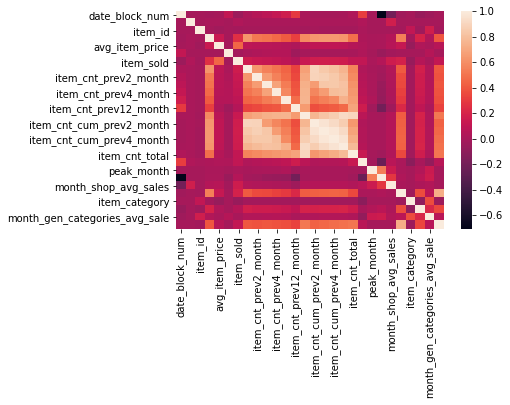

In [255]:
corr = new_sales_data.corr()
sns.heatmap(corr)

In [ ]:
# Format validation data
test.columns = ['ID', 'shopId', 'itemId']
test['dateBlockNum'] = 33
val = pd.merge(val, test, on=['dateBlockNum', 'shopId', 'itemId'], how='right')
val.drop("ID", axis = 1,inplace=True)
val.to_pickle("validation_data.pickle")

In [ ]:
# Create Test Set
test.columns = ['ID', 'shopId', 'itemId']
test['dateBlockNum'] = 34
test_set = pd.merge(new_sales_data, test, on=['dateBlockNum', 'shopId', 'itemId'], how='right')
test_set.drop('ID', axis=1, inplace=True)
test_set.drop('itemCountPerShopPerMonth', axis=1, inplace=True)
with open("testNeedsPredictions.pickle", "wb") as pick:
    pickle.dump(test_set, pick)

In [4]:
# Format training data such that only nontrivial rows with itemCountPerShopPerMonth > 0 are kept and data that is a part of the test set.
new_sales_data = pd.read_pickle("new_sales_data_train.pickle")
new_sales_data = new_sales_data[new_sales_data.itemCountPerShopPerMonth > 0]
new_sales_data2 = pd.concat([new_sales_data, filtered_train_data])
new_sales_data_final = new_sales_data2.drop_duplicates()
new_sales_data_final.to_pickle("new_sales_data_final.pickle")

In [3]:
# Get trainable data
new_sales_data_final = pd.read_pickle("new_sales_data_final.pickle")
new_sales_data_final = new_sales_data_final[new_sales_data_final.dateBlockNum < 33]
val = pd.read_pickle("validation_data.pickle")

In [4]:
# Load Models
with open("xgboostImproved2.pickle", "rb") as pick:
    model = pickle.load(pick)
with open("lr.pickle", "rb") as pick:
    lrBest = pickle.load(pick)
with open("randomForest.pickle", "rb") as pick:
    randomForest = pickle.load(pick)
with open("neighbor.pickle", "rb") as pick:
    neighbor = pickle.load(pick)

RandomForestRegressor(n_jobs=-1, random_state=42, verbose=2)

In [116]:
# Initiate Models
neighbor = KNeighborsRegressor(n_jobs = -1)
randomForest = RandomForestRegressor(n_estimators=100, n_jobs = -1, verbose=2, random_state=42)
lr = LinearRegression(n_jobs=-1)
model = XGBRegressor(max_depth=8, n_estimators=250, min_child_weight=800, colsample_by_tree=0.8, subsample=0.8, eta=0.2, seed=40)

In [ ]:
# If needed
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [6]:
# Get train/validation split
X_train = new_sales_data_final.drop('itemCountPerShopPerMonth', axis = 1)
y_train = list(new_sales_data_final['itemCountPerShopPerMonth'])

X_val = val.drop('itemCountPerShopPerMonth', axis = 1)
y_val = list(val['itemCountPerShopPerMonth'])

In [117]:
neighbor.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [79]:
randomForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 32.3min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 103.0min finished


RandomForestRegressor(n_jobs=-1, verbose=2)

In [132]:
neighbor.predict(X_train)

KeyboardInterrupt: 

In [82]:
with open("randomForest.pickle", "wb") as pick:
    pickle.dump(randomForest, pick)

In [92]:
randomForestPredictions = model.predict(X_val)

In [93]:
math.sqrt(mean_squared_error(randomForestPredictions, list(y_val)))

1.8458794920372805

In [14]:
lr.fit(X_train, y_train)
model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True, early_stopping_rounds=25)

LinearRegression(n_jobs=-1)

In [57]:
model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True, early_stopping_rounds=25)

[16:32:57] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:57] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:3.72221	validation_1-rmse:2.48541
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 25 rounds.
[1]	validation_0-rmse:3.56220	validation_1-rmse:2.32988
[2]	validation_0-rmse:3.45493	validation_1-rmse:2.24105
[3]	validation_0-rmse:3.37669	validation_1-rmse:2.20932
[4]	validation_0-rmse:3.32119	validation_1-rmse:2.15762
[5]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_by_tree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             eta=0.2, gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.200000003,
             max_delta_step=0, max_depth=8, min_child_weight=800, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, random_state=40, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=40, subsample=0.8, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [ ]:
with open ("lr3.pickle", "wb") as pick:
    pickle.dump(lr, pick)
    
with open("xgboostImproved2.pickle", "wb") as pick:
    pickle.dump(model, pick)
    
with open("neighbor.pickle", "wb") as pick:
    pickle.dump(neighbor, pick)
    
with open("randomForest.pickle", "wb") as pick:
    pickle.dump(randomForest, pick)

In [122]:
model

XGBRegressor(base_score=None, booster=None, colsample_by_tree=0.8,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, eta=0.2, gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=8,
             min_child_weight=800, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=40, subsample=0.8, tree_method=None,
             validate_parameters=None, verbosity=None)

In [12]:
# Training Predictions
xgboost_train_predictions = list(model.predict(X_train).clip(0, 20))
lrBest_train_predictions = list(lrBest.predict(X_train).clip(0, 20))
randomForest_train_predictions = list(randomForest.predict(X_train).clip(0,20))
neighbor_train_predictions = list(neighbor.predict(X_train).clip(0, 20))

stack_first_level = pd.DataFrame()
stack_first_level['xgboost'] = xgboost_train_predictions
stack_first_level['linearRegression'] = lrBest_train_predictions
stack_first_level['randomForest'] = randomForest_train_predictions
stack_first_level['neighbor'] = neighbor_train_predictions

# Meta Model
lr_second_level = LinearRegression(n_jobs=-1)
lr_second_level.fit(stack_first_level, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.7s finished


LinearRegression(n_jobs=-1)

In [13]:
# Validation Predictions
xgboost_validation_predictions = list(model.predict(X_val).clip(0, 20))
lrBest_validation_predictions = list(lrBest.predict(X_val).clip(0, 20))
randomForest_validation_predictions = list(randomForest.predict(X_val).clip(0,20))
neighbor_validation_predictions = list(neighbor.predict(X_val).clip(0, 20))


stack_first_level = pd.DataFrame()
stack_first_level['xgboost'] = xgboost_validation_predictions
stack_first_level['linearRegression'] = lrBest_validation_predictions
stack_first_level['randomForest'] = randomForest_validation_predictions
stack_first_level['neighbor'] = neighbor_validation_predictions

# Meta Model
stacked_validation_predictions = lr_second_level.predict(stack_first_level).clip(0,20)

rsme = math.sqrt(mean_squared_error(stacked_validation_predictions, list(y_val)))
print(rsme)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.1s finished


2.400372163402071


In [15]:
stack_first_level

,xgboost,linearRegression,randomForest
0,0.535574,0.071111,0.73
1,0.000000,0.003933,0.00
2,0.921502,0.890276,1.08
3,0.355925,0.286004,0.43
4,0.000000,0.514656,0.00
...,...,...,...
214195,0.230657,0.351671,0.35
214196,0.000000,0.039577,0.00
214197,0.097608,0.000000,0.26
214198,0.000000,0.000000,0.00


In [17]:
# Test Predictions
with open("testNeedsPredictions.pickle", "rb") as pick:
    needsPredictions = pickle.load(pick)

xgboost_test_predictions = list(model.predict(needsPredictions).clip(0, 20))
lrBest_test_predictions = list(lrBest.predict(needsPredictions).clip(0, 20))
randomForest_test_predictions = list(randomForest.predict(needsPredictions).clip(0,20))
neighbor_test_predictions = list(neighbor.predict(X_val).clip(0, 20))

stack_first_level = pd.DataFrame()
stack_first_level['xgboost'] = xgboost_test_predictions
stack_first_level['linearRegression'] = lrBest_test_predictions
stack_first_level['randomForest'] = randomForest_test_predictions
stack_first_level['neighbor'] = neighbor_test_predictions

# Meta Model
stacked_test_predictions = lr_second_level.predict(stack_first_level).clip(0, 20)

print(stacked_test_predictions)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


[1.69217145 0.         1.88242435 ... 0.08095008 0.         0.32235574]


In [138]:
stack_first_level

,xgboost,linearRegression,randomForest
0,0.535574,0.070936,0.73
1,0.000000,0.000000,0.00
2,0.921502,0.847545,1.08
3,0.355925,0.327684,0.43
4,0.000000,1.092005,0.00
...,...,...,...
214195,0.230657,0.249780,0.35
214196,0.000000,0.012891,0.00
214197,0.097608,0.058603,0.26
214198,0.000000,0.000000,0.00


In [7]:
#Individual Model Validation
val_predictions = lrBest.predict(X_val).clip(0,20)
print(list(val_predictions))
print(list(y_val))
print(math.sqrt(mean_squared_error(val_predictions, list(y_val))))

with open("testNeedsPredictions.pickle", "rb") as pick:
    needsPredictions = pickle.load(pick)
    
predictionTest = lrBest.predict(needsPredictions).clip(0, 20)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
print(predictionTest)

[0.07111056 0.0039326  0.89027565 ... 0.         0.         0.        ]


In [10]:
# Submission
sample_submission.item_cnt_month = predictionTest

sample_submission.to_csv('submission16.csv', index=False)


In [11]:
sample_submission

,ID,item_cnt_month
0,0,0.071111
1,1,0.003933
2,2,0.890276
3,3,0.286004
4,4,0.514656
...,...,...
214195,214195,0.351671
214196,214196,0.039577
214197,214197,0.000000
214198,214198,0.000000
